### 13. Encoder Decoder Model With Attention- ``NMT``

This notebook is just an exansion from what we did in the previous notebook. We are going to create an Encoder Decoder model with attention. The rest of the notebook will remain the same as in the previous notebook, we are going to tweek few things.


### Imports

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


import re, os, time, unicodedata

tf.__version__

'2.6.0'

### Mounting the drive

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = "/content/drive/My Drive/NLP Data/seq2seq/spa-en/spa.txt"
os.path.exists(file_path)

True

We will use spainish as our source language and english as our target language in this example.

In [4]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

In [5]:
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()
    # Adding the start and end of sequences tokens 
    # w = '<sos> ' + w + ' <eos>'
    return w

### Data and text processing.

We need to remove accents, lower case the sentences and replace everything with space except (a-z, A-Z, ".", "?", "!", ",").

In [6]:
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'

TARGET_FOR_INPUT = 'target_for_input'
NUM_SAMPLES = 20000 #40000
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 128
HIDDEN_DIM= 1024

BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 10  # Number of epochs to train for.

In [7]:
# Load the dataset: sentence in english, sentence in spanish 
df=pd.read_csv(file_path, sep="\t", header=None, names=[TARGET_COLUMN, INPUT_COLUMN], usecols=[0,1], 
               nrows=NUM_SAMPLES)

# Preprocess the input data
input_data=df[INPUT_COLUMN].apply(lambda x : preprocess_sentence(x)).tolist()
# Preprocess and include the end of sentence token to the target text
target_data=df[TARGET_COLUMN].apply(lambda x : preprocess_sentence(x)+ ' <eos>').tolist()
# Preprocess and include a start of setence token to the input text to the decoder, it is rigth shifted
target_input_data=df[TARGET_COLUMN].apply(lambda x : '<sos> '+ preprocess_sentence(x)).tolist()

print(input_data[:5])
print(target_data[:5])
print(target_input_data[:5])

['ve .', 'vete .', 'vaya .', 'vayase .', 'hola .']
['go . <eos>', 'go . <eos>', 'go . <eos>', 'go . <eos>', 'hi . <eos>']
['<sos> go .', '<sos> go .', '<sos> go .', '<sos> go .', '<sos> hi .']


### Tokenization

* Tokenize the data, to convert the raw text into a sequence of integers. First, we create a Tokenizer object from the keras library and fit it to our text (one tokenizer for the input and another one for the output).
* Extract sequence of integers from the text: we call the ``text_to_sequence`` method of the tokenizer for every input and output text.
* Calculate the maximum length of the input and output sequences.

In [8]:
tokenizer_inputs = Tokenizer(
    num_words = MAX_VOCAB_SIZE, filters=""
)
tokenizer_inputs.fit_on_texts(input_data)
input_sequences = tokenizer_inputs.texts_to_sequences(input_data)

input_max_len = max(len(s) for s in input_sequences)
print('max input length: ', input_max_len)

# Show some example of tokenize sentences, useful to check the tokenization
print(input_data[1000])
print(input_sequences[1000])


max input length:  17
tomas lo intento .
[60, 15, 765, 1]


We can do the same thing to the output sequences.

In [9]:

# Create a tokenizer for the output texts and fit it to them 
tokenizer_outputs = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer_outputs.fit_on_texts(target_data)
tokenizer_outputs.fit_on_texts(target_input_data)

# Tokenize and transform output texts to sequence of integers
target_sequences = tokenizer_outputs.texts_to_sequences(target_data)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_input_data)

# determine maximum length output sequence
target_max_len = max(len(s) for s in target_sequences)
print('max target length: ', target_max_len)

print(target_data[1000])
print(target_sequences[1000])
print(target_input_data[1000])


max target length:  9
tom tried . <eos>
[7, 414, 1, 2]
<sos> tom tried .


### Creating vocabularies

Using the tokenizer we have created previously we can retrieve the vocabularies, one to match word to integer (word2idx) and a second one to match the integer to the corresponding word (idx2word).


In [10]:
# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output and input words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1
num_words_inputs = len(word2idx_inputs) + 1

# map indexes back into real words
# so we can view the results
idx2word_inputs = {v:k for k, v in word2idx_inputs.items()}
idx2word_outputs = {v:k for k, v in word2idx_outputs.items()}

Found 7183 unique input tokens.
Found 3669 unique output tokens.


### Padding Sequences
Padding the sentences: we need to pad zeros at the end of the sequences so that all sequences have the same length. Otherwise, we won't be able train the model on batches.

In [11]:

# pad the input sequences
encoder_inputs = pad_sequences(input_sequences,
                               maxlen=input_max_len, padding='post', truncating="post")
print("encoder_inputs.shape:", encoder_inputs.shape)


# pad the decoder input sequences
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=target_max_len, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

# pad the target output sequences
decoder_targets = pad_sequences(target_sequences, maxlen=target_max_len, padding='post')
print("decoder_targets.shape:", decoder_targets.shape)


encoder_inputs.shape: (20000, 17)
decoder_inputs[0]: [ 3 31  1  0  0  0  0  0  0]
decoder_inputs.shape: (20000, 9)
decoder_targets.shape: (20000, 9)


### Creating a Batch Data Generator

* Create a batch data generator: we want to train the model on batches, group of sentences, so we need to create a Dataset using the tf.data library and the function ``batch_on_slices`` on the input and output sequences.

In [12]:
BUFFER_SIZE = len(input_data)
dataset = tf.data.Dataset.from_tensor_slices(
    (encoder_inputs, decoder_inputs, decoder_targets)
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

### Encoder Decoder Model. (This will remain the same as from the prevoius notebook)

For a better understanding, we can divide the model in three basic components:

![img](https://github.com/edumunozsala/NMT-encoder-decoder-Attention/raw/ca7d7f969a17ddf390f707fceb22d5881d33b1c3/images/encoder_decoder_RNN.jpeg)

*  **The encoder:** Layers of recurrent units where in each time step, receive a an input token, collects relevant information and produce a hidden state. Depends on the type of RNN, in our example a LSTM, the unit "mixes" the current hidden state and the input and return an output, discarded, and a new hidden state. 

* **The encoder vector:** it is the last hidden state of the encoder and it tries to contain as much of the useful input information as possible to help the decoder get the best results. It is only information from the input that the decoder will get.

* **The decoder:** Layers of recurrent units, i.e. LSTMs, where each unit produces an output at a time step t. The hidden state of the first unit is the encoder vector and the rest of units accept the hidden state from the previous unit. The output is calculated using a **``_softmax_``** function to obtain a probability for every token in the output vocabulary.




### Encoder Class


In [13]:
class Encoder(keras.Model):
  def __init__(self, vocab_size, embedding_dim, hidden_dim):
    super(Encoder, self).__init__()
    self.hidden_dim = hidden_dim

    self.embedding = keras.layers.Embedding(
        vocab_size, embedding_dim
    )
    self.lstm = keras.layers.LSTM(hidden_dim,
                                  return_sequences=True,
                                  return_state=True
                                  )
    
  def call(self, input_sequence, states):
    embedded  = self.embedding(input_sequence)
    output, h_0, c_0 = self.lstm(embedded, initial_state= states)
    return output, h_0, c_0 

  def init_states(self, batch_size):
    return(
        tf.zeros([batch_size, self.hidden_dim]),
        tf.zeros([batch_size, self.hidden_dim]),
    )


### The Attention Mechanism
The previously described model based on RNNs has a serious problem when working with long sequences, because the information of the first tokens is lost or diluted as more tokens are processed. The context vector has been given the responsibility of encoding all the information in a given source sentence in to a vector of few hundred elements. it made it challenging for the models to deal with long sentences. A solution was proposed in Bahdanau et al., 2014 [4] and Luong et al., 2015,[5].

They introduce a technique called **_"Attention"_**, which highly improved the quality of machine translation systems. Attention allows the model to focus on the relevant parts of the input sequence as needed, accessing to all the past hidden states of the encoder, instead of just the last one. At each decoding step, the decoder gets to look at any particular state of the encoder and can selectively pick out specific elements from that sequence to produce the output. We will focus on the Luong perspective.

### Loung Attention layer
![img](https://github.com/edumunozsala/NMT-encoder-decoder-Attention/raw/ca7d7f969a17ddf390f707fceb22d5881d33b1c3/images/luong_attention.PNG)

There are two relevant points to focus on:

* **The alignment vector:** is a vector with the same length that the input or source sequence and is computed at every time step of the decoder. Each of its values is the score (or the probability) of the corresponding word within the source sequence, they tell the decoder what to focus on at each time step.

     There are three ways to calculate the alingment scores:

  * **Dot product:** we only need to take the hidden states of the encoder and multiply them by the hidden state of the decoder
  * **General:** very similar to dot product but a weight matrix is included.
  * **Concat:** the decoder hidden state and encoder hidden states are added together first before being passed through a Linear layer with an tanh activation function and finally multiply by a weight matrix.

  ![img](https://github.com/edumunozsala/NMT-encoder-decoder-Attention/raw/ca7d7f969a17ddf390f707fceb22d5881d33b1c3/images/formula_luong_attention.PNG)

  The alignment scores are softmaxed so that the weights will be between 0 to 1.

* **The context vector:** It's the weighted average sum of the encoder's output, the dot product of the alignment vector and the encoder's output.



In [14]:
class LuongAttention(keras.Model):
  def __init__(self, rnn_size, attention_func):
    super(LuongAttention, self).__init__()
    self.attention_func = attention_func
    if attention_func not in ['dot', 'general', 'concat']:
      raise ValueError(
        'Attention score must be either dot, general or concat but got %s.' % attention_func  
      )
    if attention_func == 'general':
      # General score function
      self.wa = keras.layers.Dense(rnn_size)
    elif attention_func == 'concat':
      self.wa = keras.layers.Dense(rnn_size, activation='tanh')
      self.va = keras.layers.Dense(1)

  def call(self, decoder_output, encoder_output):
    if self.attention_func == 'dot':
      score = tf.matmul(decoder_output, encoder_output, transpose_b=True) # (batch_size, 1, max_len)
    elif self.attention_func == 'general':
      score = tf.matmul(decoder_output, self.wa(
                encoder_output), transpose_b=True) #(batch_size, 1, max_len)
    elif self.attention_func == 'concat':
      decoder_output = tf.tile(
                decoder_output, [1, encoder_output.shape[1], 1]) #shape (batch size, max len,hidden_dim)
      score = self.va(
                self.wa(tf.concat((decoder_output, encoder_output), axis=-1))) # (batch_size, max len, 1)
      score = tf.transpose(score, [0, 2, 1]) #(batch_size, 1, max_len)
    
    alignment = tf.keras.activations.softmax(score, axis=-1) #(batch_size, 1, max_len)
    context = tf.matmul(alignment, encoder_output) # (batch_size, 1, hidden_dim)
    return context, alignment


### Decoder With Attention
Once our Attention Class has been defined, we can create the decoder. The complete sequence of steps when calling the decoder are:

* Generate the encoder hidden states as usual, one for every input token
* Apply a RNN to produce a new hidden state, taking its previous hidden state and the target output from the previous time step
* Calculate the alignment scores as described previously
* Calculate the context vector
* In the last operation, the context vector is concatenated with the decoder hidden state we generated previously, then it is passed through a linear layer which acts as a classifier for us to obtain the probability scores of the next predicted word



In [15]:
class Decoder(keras.Model):
  def __init__(self, vocab_size, embedding_dim,
               hidden_dim, attention_func):
    super(Decoder, self).__init__()

    self.attention = LuongAttention(hidden_dim, attention_func)
    
    self.hidden_dim = hidden_dim
    self.embedding = keras.layers.Embedding(
        vocab_size, embedding_dim
    )
    self.lstm = keras.layers.LSTM(
         hidden_dim, return_sequences=True, return_state=True
    )

    self.wc = keras.layers.Dense(hidden_dim, activation='tanh')
    self.out = keras.layers.Dense(vocab_size)

  def call(self, input_sequence, state, encoder_output):
    # Remember that the input to the decoder
    # is now a batch of one-word sequences,
    # which means that its shape is (batch_size, 1)
    embedded = self.embedding(input_sequence)
    output, h_0, c_0 = self.lstm(embedded, initial_state=state)
    # Use self.attention to compute the context and alignment vectors
    # context vector's shape: (batch_size, 1, hidden_dim)
    # alignment vector's shape: (batch_size, 1, source_length)
    context, alignment = self.attention(output, encoder_output)
    # Combine the context vector and the LSTM output
    # Before combined, both have shape of (batch_size, 1, hidden_dim),
    # so let's squeeze the axis 1 first
    # After combined, it will have shape of (batch_size, 2 * hidden_dim)
    output =  tf.concat(
            [tf.squeeze(context, 1), tf.squeeze(output, 1)], 1)
    # output now has shape (batch_size, hidden_dim)
    output = self.wc(output)
    # Finally, it is converted back to vocabulary space: (batch_size, vocab_size

    logits = self.out(output)
    return logits, h_0, c_0, alignment


For testing purposes, we create a decoder and call it to check the output shapes:

In [16]:
#Set the length of the input and output vocabulary
num_words_inputs = len(word2idx_inputs) + 1
num_words_output = len(word2idx_outputs) + 1

ATTENTION_FUNC = "general"

#Create the encoder
encoder = Encoder(num_words_inputs, EMBEDDING_DIM, HIDDEN_DIM)
decoder = Decoder(num_words_output, EMBEDDING_DIM, HIDDEN_DIM, ATTENTION_FUNC)

# Call the encoder and then the decoder
initial_state = encoder.init_states(1)
encoder_outputs = encoder(tf.constant([[1]]), initial_state)
decoder_outputs = decoder(tf.constant(
    [[1]]), encoder_outputs[1:], encoder_outputs[0])


### Loss function and metrics

The loss functions and metrics will remain unchanged from the previous notebook.



In [17]:
def loss_func(targets, logits):
  crossentropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=True)
  # Mask padding values, they do not have to compute for loss
  mask = tf.math.logical_not(tf.math.equal(targets, 0))
  mask = tf.cast(mask, dtype=tf.int64) 
  loss = crossentropy(targets, logits, sample_weight=mask)
  return loss
     

In [18]:
def accuracy_fn(y_true, y_pred):
  # y_pred shape is batch_size, seq length, vocab size
  # y_true shape is batch_size, seq length
  pred_values = keras.backend.cast(keras.backend.argmax(y_pred, axis=-1), dtype='int32')
  correct = keras.backend.cast(keras.backend.equal(y_true, pred_values), dtype='float32')

  # 0 is padding, don't include those
  mask = keras.backend.cast(keras.backend.greater(y_true, 0),
                            dtype='float32')
  n_correct = keras.backend.sum(mask * correct)
  n_total = keras.backend.sum(mask)
  return n_correct / n_total


### Training

Now we can define our step train function, to train a batch data. It is very similar to the one we coded for the previous notebook model without attention but this time we pass all the hidden states returned by the encoder to the decoder. And we need to create a loop to iterate through the target sequences, calling the decoder for each one and calculating the loss function comparing the decoder output to the expected target.

In [19]:
@tf.function
def train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer):
    loss = 0.
    acc = 0.
    logits = None
    
    with tf.GradientTape() as tape:
        en_outputs = encoder(input_seq, en_initial_states)
        en_states = en_outputs[1:]
        de_state_h, de_state_c = en_states

        # We need to create a loop to iterate through the target sequences
        for i in range(target_seq_out.shape[1]):
            # Input to the decoder must have shape of (batch_size, length)
            # so we need to expand one dimension
            decoder_in = tf.expand_dims(target_seq_in[:, i], 1)
            logit, de_state_h, de_state_c, _ = decoder(
                decoder_in, (de_state_h, de_state_c), en_outputs[0])

            # The loss is now accumulated through the whole batch
            loss += loss_func(target_seq_out[:, i], logit)
            # Store the logits to calculate the accuracy
            logit = keras.backend.expand_dims(logit, axis=1)
            if logits is None:
                logits = logit
            else:
                logits = keras.backend.concatenate((logits,logit), axis=1)
        # Calculate the accuracy for the batch data        
        acc = accuracy_fn(target_seq_out, logits)
    # Update the parameters and the optimizer
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss / target_seq_out.shape[1], acc


Our train function receives three sequences:

**Input sequence:** array of integers of shape [batch_size, max_seq_len, embedding dim]. It is the input sequence to the encoder.

**target sequence:** array of integers of shape [batch_size, max_seq_len, embedding dim]. It is the target of our model, the output that we want for our model.

**Target input sequence:** array of integers of shape [batch_size, max_seq_len, embedding dim]. It is the input sequence to the decoder because we use Teacher Forcing.


### Oh Teacher Forcing
Teacher forcing is a training method critical to the development of deep learning models in NLP. It is a way for quickly and efficiently training recurrent neural network models that use the ground truth from a prior time step as input.

In a recurrent network usually the input to a RNN at the time step t is the output of the RNN in the previous time step, t-1. But with teacher forcing we can use the actual output to improve the learning capabilities of the model.

_"Teacher forcing works by using the actual or expected output from the training dataset at the current time step y(t) as input in the next time step X(t+1), rather than the output generated by the network. So, in our example, the input to the decoder is the target sequence right-shifted, the target output at time step t is the decoder input at time step t+1."_

When our model output do not vary from what was seen by the model during training, teacher forcing is very effective. But if we need a more "creative" model, where given an input sequence there can be several possible outputs, we should avoid this technique or apply it randomly (only in some random time steps).

Now, we can code the whole training process:


In [20]:
def fit(encoder, decoder, dataset, n_epochs, batch_size, optimizer, checkpoint, checkpoint_prefix):
    
    losses = []
    accuracies = []

    for e in range(n_epochs):
        # Get the initial time
        start = time.time()
        # Get the initial state for the encoder
        en_initial_states = encoder.init_states(batch_size)
        # For every batch data
        for batch, (input_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
            # Train and get the loss value 
            loss, accuracy = train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer)
        
            if batch % 100 == 0:
                # Store the loss and accuracy values
                losses.append(loss)
                accuracies.append(accuracy)
                print('Epoch {} Batch {} Loss {:.4f} Acc:{:.4f}'.format(e + 1, batch, loss.numpy(), accuracy.numpy()))
                
        # saving (checkpoint) the model every 2 epochs
        if (e + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
        print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))
        
    return losses, accuracies

We are almost ready, our last step include a call to the main train function and we create a checkpoint object to save our model. Because the training process require a long time to run, every two epochs we save it. Later we can restore it and use it to make predictions.

In [21]:
# Create an Adam optimizer and clips gradients by norm
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
# Create a checkpoint object to save the model
checkpoint_dir = './training_ckpt_seq2seq_att'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

losses, accuracies = fit(encoder, decoder, dataset, 
                                EPOCHS, BATCH_SIZE, 
                         optimizer, checkpoint, checkpoint_prefix)

Epoch 1 Batch 0 Loss 5.1443 Acc:0.0000
Epoch 1 Batch 100 Loss 2.1913 Acc:0.4190
Epoch 1 Batch 200 Loss 1.9849 Acc:0.4504
Epoch 1 Batch 300 Loss 1.6921 Acc:0.5179
Time taken for 1 epoch 79.6839 sec

Epoch 2 Batch 0 Loss 1.6905 Acc:0.5432
Epoch 2 Batch 100 Loss 1.5678 Acc:0.5571
Epoch 2 Batch 200 Loss 1.5056 Acc:0.5577
Epoch 2 Batch 300 Loss 1.4290 Acc:0.6108
Time taken for 1 epoch 48.3789 sec

Epoch 3 Batch 0 Loss 1.3067 Acc:0.6029
Epoch 3 Batch 100 Loss 1.2139 Acc:0.6575
Epoch 3 Batch 200 Loss 1.1159 Acc:0.6800
Epoch 3 Batch 300 Loss 1.0038 Acc:0.6474
Time taken for 1 epoch 47.6628 sec

Epoch 4 Batch 0 Loss 0.8628 Acc:0.6962
Epoch 4 Batch 100 Loss 0.8903 Acc:0.7151
Epoch 4 Batch 200 Loss 0.8578 Acc:0.7083
Epoch 4 Batch 300 Loss 0.7999 Acc:0.7598
Time taken for 1 epoch 48.1545 sec

Epoch 5 Batch 0 Loss 0.5670 Acc:0.7879
Epoch 5 Batch 100 Loss 0.5863 Acc:0.7626
Epoch 5 Batch 200 Loss 0.4846 Acc:0.8319
Epoch 5 Batch 300 Loss 0.5071 Acc:0.8147
Time taken for 1 epoch 47.6263 sec

Epoch 6 Ba

### Model Evaulation

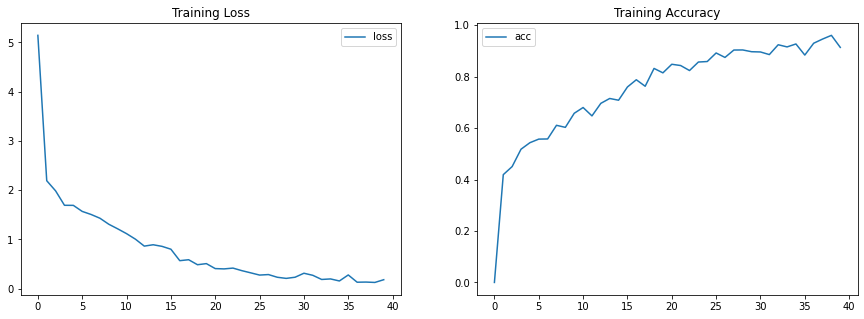

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(losses, label='loss')
#plt.plot(results.history['val_loss'], label='val_loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
#plt.plot(results.history['val_accuracy_fn'], label='val_acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

### Inference
To restore the lastest checkpoint, saved model, you can run the following cell:

In [23]:
# Create an Adam optimizer and clips gradients by norm
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
# Create a checkpoint object to save the model
checkpoint_dir = './training_ckpt_seq2seq_att'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In the prediction step, our input is a sequence of length one, the ``sos`` token, then we call the encoder and ``decoder`` repeatedly until we get the eos token or reach the maximum length defined.

In [26]:
def predict(input_text, input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs):
    if input_text is None:
        input_text = input_data[np.random.choice(len(input_data))]
    print(input_text)
    # Tokenize the input text
    input_seq = tokenizer_inputs.texts_to_sequences([input_text])
    # Pad the sentence
    input_seq = pad_sequences(input_seq, maxlen=input_max_len, padding='post')
    # Get the encoder initial states
    en_initial_states = encoder.init_states(1)
    # Get the encoder outputs or hidden states
    en_outputs = encoder(tf.constant(input_seq), en_initial_states)
    # Set the decoder input to the sos token
    de_input = tf.constant([[word2idx_outputs['<sos>']]])
    # Set the initial hidden states of the decoder to the hidden states of the encoder
    de_state_h, de_state_c = en_outputs[1:]
    
    out_words = []
    alignments = []

    while True:
        # Get the decoder with attention output
        de_output, de_state_h, de_state_c, alignment = decoder(
            de_input, (de_state_h, de_state_c), en_outputs[0])
        de_input = tf.expand_dims(tf.argmax(de_output, -1), 0)
        # Detokenize the output
        out_words.append(idx2word_outputs[de_input.numpy()[0][0]])
        # Save the aligment matrix
        alignments.append(alignment.numpy())

        if out_words[-1] == '<eos>' or len(out_words) >= 20:
            break
    # Join the output words
    # print(' '.join(out_words))
    return np.array(alignments), input_text.split(' '), out_words


he ate out . <eos>
el salio a comer .


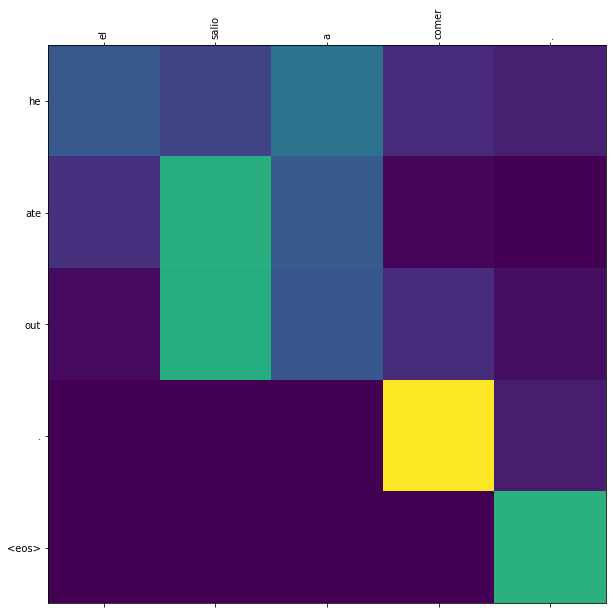

In [29]:

n_predictions=1
test_sents = input_data[1200:(1200+n_predictions)]
print(target_data[1200])

# Create the figure to plot in
fig = plt.figure(figsize=(10, 20))
for i, test_sent in enumerate(test_sents):
  # Call the predict function to get the translation
  alignments, source, prediction = predict(test_sent, input_max_len, tokenizer_inputs, 
                                                    word2idx_outputs, idx2word_outputs)
  attention = np.squeeze(alignments, (1, 2))
  # Create a subplot
  ax = fig.add_subplot(1, n_predictions, i+1)
  ax.matshow(attention[:len(prediction), :len(source)], cmap='viridis')
  ax.set_xticklabels([''] + source, rotation=90)
  ax.set_yticklabels([''] + prediction)
plt.show()

In [33]:

for inp, trg in zip(input_data[:10], target_data[:10]):
  alignments, source, prediction = predict(inp, input_max_len, tokenizer_inputs, 
                                                      word2idx_outputs, idx2word_outputs)
  print("input: > ", inp)
  print("target: > ", trg.replace("<eos>", ""))
  print("predicted: = ", " ".join(prediction).replace("<eos>", ""))
  print()
  print("*"*100)
  print()

ve .
input: >  ve .
target: >  go . 
predicted: =  that s amazing . 

****************************************************************************************************

vete .
input: >  vete .
target: >  go . 
predicted: =  go . 

****************************************************************************************************

vaya .
input: >  vaya .
target: >  go . 
predicted: =  go . 

****************************************************************************************************

vayase .
input: >  vayase .
target: >  go . 
predicted: =  go on . 

****************************************************************************************************

hola .
input: >  hola .
target: >  hi . 
predicted: =  hi . 

****************************************************************************************************

corre !
input: >  corre !
target: >  run ! 
predicted: =  run ! 

***************************************************************************************************

In [34]:
for inp, trg in zip(input_data[2210:2220], target_data[2210:2220]):
  alignments, source, prediction = predict(inp, input_max_len, tokenizer_inputs, 
                                                      word2idx_outputs, idx2word_outputs)
  print("input: > ", inp)
  print("target: > ", trg.replace("<eos>", ""))
  print("predicted: = ", " ".join(prediction).replace("<eos>", ""))
  print()
  print("*"*100)
  print()

dije que pararas .
input: >  dije que pararas .
target: >  i said stop . 
predicted: =  i said stop . 

****************************************************************************************************

dije que te detuvieras .
input: >  dije que te detuvieras .
target: >  i said stop . 
predicted: =  i said stop . 

****************************************************************************************************

yo dije eso .
input: >  yo dije eso .
target: >  i said that . 
predicted: =  i said that . 

****************************************************************************************************

yo vi un ovni .
input: >  yo vi un ovni .
target: >  i saw a ufo . 
predicted: =  i saw a ufo . 

****************************************************************************************************

vi a un perro .
input: >  vi a un perro .
target: >  i saw a dog . 
predicted: =  i saw a dog . 

**********************************************************************************

### Credits

As we can see the encoder decoder model with Attention mechanisim performs better.

* [edumunozsala](https://github.com/edumunozsala/NMT-encoder-decoder-Attention/blob/main/Intro-seq2seq-Encoder-Decoder-ENG-SPA-translator-tf2.ipynb)
